In [2]:
import numpy as np 
import scipy
from scipy.stats import *
from sklearn.gaussian_process.kernels import RBF
import seaborn as sns 
import matplotlib.pyplot as plt 

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

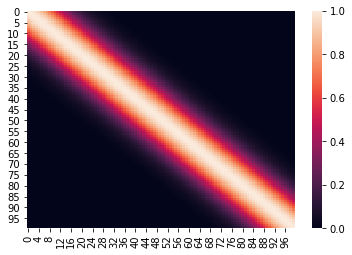

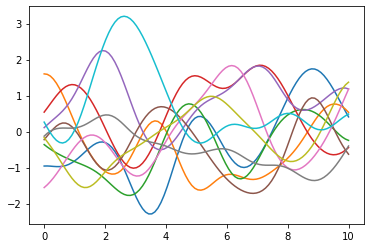

In [2]:
x = np.linspace(0,10,100)

#change this to see effects of length scale on output 
kern = RBF(1.)

cov  = kern.__call__(x.reshape(-1,1),x.reshape(-1,1))

sns.heatmap(cov)
plt.show()


#draw some realization  from the Gaussian process
y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=10)

for i in range(len(y)):
    sns.lineplot(x,y[i,:])
plt.show()

In [132]:
def rbf(x1,x2,ls=1):
    #x1,x2: 2 vector
    return np.exp(-(x1-x2)**2 / ls)
def kern(ls):
    return partial(rbf,ls=ls)

<AxesSubplot:>

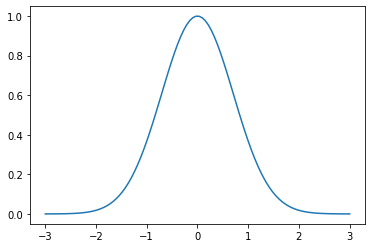

In [133]:
x = np.linspace(-3,3,100)

sns.lineplot(x,[rbf(0,i) for i in x])

In [5]:
x = np.linspace(0,10,100)

In [159]:
def _rbf(x1,x2,ls=1):
    return np.exp(-(x1-x2)**2 / ls)

def _kern(ls):
    return partial(_rbf,ls=ls)

def rbf(x1,x2,ls=1):
#     #return covariance matrix
#     cov = np.zeros((len(x1),len(x2)))
#     k = _kern(ls)
#     for i in range(len(x1)):
#         for j in range(len(x2)):
#             cov[i ,j] = k(x1[i],x2[j])
#     return cov
#    pairwise distance instead of doing 2 for loops
    dist = scipy.spatial.distance.cdist(x1.reshape(-1,1),x2.reshape(-1,1))
    return np.exp(- dist**2 / ls)
        

def kern(ls):
    return partial(rbf,ls=ls)
    

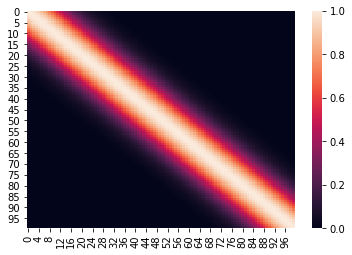

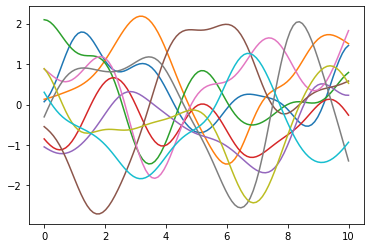

In [202]:
cov = rbf(x,x,ls=2)
sns.heatmap(cov)
plt.show()


#draw some realization  from the Gaussian process
y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=10)

for i in range(len(y)):
    sns.lineplot(x,y[i,:])
plt.show()

# Now, let's see what's inside this GP thing

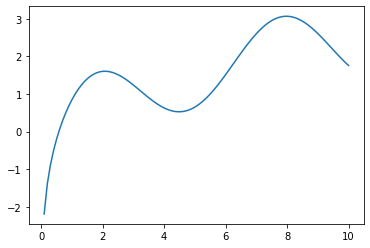

In [161]:
from functools import partial
x = np.linspace(0,10,100)
f = lambda x: np.log(x) + np.sin(x)
sns.lineplot(x,f(x));

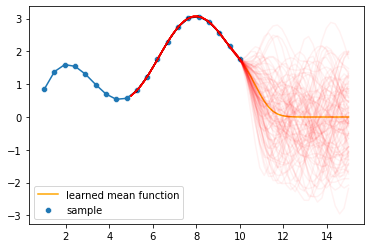

In [308]:
x1 = np.linspace(1,10,20)
x2 = np.linspace(5,15,50)
ls = 1

# Rasumussen & Williams, Gaussian processes for machine learning , chapter 2, eq 2.19
# note that there is a better way to do this as indicated by the alg at the end of the chapter 
# which use a linear solver, instead of inverting this matrix, which is more stable. This is done 
# for demonstration purpose
y2 = rbf(x2,x1,ls) @ np.linalg.inv(rbf(x1,x1)) @ f(x1)
covy2 = rbf(x2,x2,ls) - rbf(x2,x1,ls) @ np.linalg.inv(rbf(x1,x1,ls)) @ rbf(x1,x2,ls)


sns.scatterplot(x1,f(x1),label='sample')
sns.lineplot(x1,f(x1))

sns.lineplot(x2,y2,label='learned mean function',color='orange')
realization = np.random.multivariate_normal(mean=y2, cov=covy2, size=100)
for i in range(100):
    sns.lineplot(x2,realization[i,:],color='red',alpha=0.05)



<AxesSubplot:>

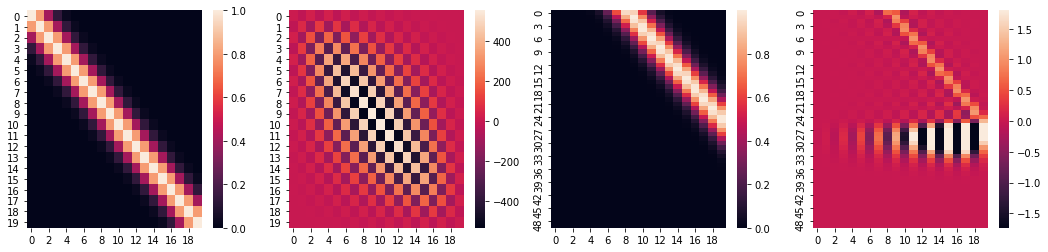

In [313]:


plt.figure(figsize=(18,4))

# covariance of observed data
plt.subplot(1,4,1)
sns.heatmap(rbf(x1,x1))

# precision of observed data
plt.subplot(1,4,2)
sns.heatmap(np.linalg.inv(rbf(x1,x1)))

#covariance of new data with respect to observed
# (how varied the new data should be )
plt.subplot(1,4,3)
sns.heatmap(rbf(x2,x1,ls))

#estimation of the new data
plt.subplot(1,4,4)
sns.heatmap(rbf(x2,x1,ls) @ np.linalg.inv(rbf(x1,x1)),robust=True)


bisecting the 4th matrix into 2 component

<AxesSubplot:>

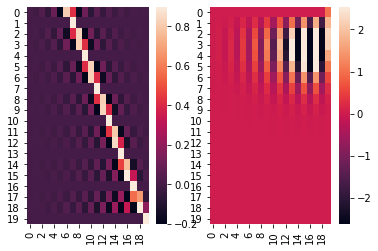

In [311]:
# the part that varies with observed
plt.subplot(1,2,1)
x3 = np.linspace(4,10,20)
sns.heatmap(rbf(x3,x1,ls) @ np.linalg.inv(rbf(x1,x1)),robust=True)

#the part that's confused and don't know to to move it move it
plt.subplot(1,2,2)
x3 = np.linspace(10,15,20)
sns.heatmap(rbf(x3,x1,ls) @ np.linalg.inv(rbf(x1,x1)),robust=True)


In [200]:
x = np.array([10,11,12])
np.linalg.inv(rbf(x,x))

array([[ 1.17809521, -0.49205091,  0.15943785],
       [-0.49205091,  1.36203083, -0.49205091],
       [ 0.15943785, -0.49205091,  1.17809521]])

In [ ]:
the function rbf(x2,x1,ls) @ np.linalg.inv(rbf(x1,x1)) is called the weight function, see page 25 of the book

# Let put it to some good use 

In [208]:
def gp_predict(x1,y1,x2,kern):
    assert len(x1) == len(y1)
    y2 = kern(x2,x1) @ np.linalg.inv(kern(x1,x1)) @ y1
    covy2 = kern(x2,x2) - kern(x2,x1) @ np.linalg.inv(kern(x1,x1)) @ kern(x1,x2)
    return y2, covy2
#for a single point predict, se eq 2.27 

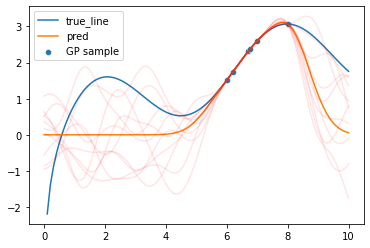

In [209]:
x = np.linspace(0,10,100)

gpx = np.array([6,6.2,6.7,6.77,7,8])
gpy = f(gpx)
k = kern(ls=1)
m,cov = gp_predict(gpx,gpy,x,k)


sns.lineplot(x,f(x),label='true_line')
sns.lineplot(x,m,label='pred')

sns.scatterplot(gpx,gpy,label='GP sample')

realization = np.random.multivariate_normal(mean=m, cov=cov, size=100)
for i in range(10):
    sns.lineplot(x,realization[i,:],color='red',alpha=0.1)


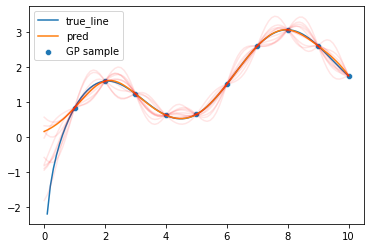

In [213]:
x = np.linspace(0,10,100)

gpx = np.linspace(1,10,10)
gpy = f(gpx)
k = kern(ls=1)
m,cov = gp_predict(gpx,gpy,x,k)


sns.lineplot(x,f(x),label='true_line')
sns.lineplot(x,m,label='pred')

sns.scatterplot(gpx,gpy,label='GP sample')

realization = np.random.multivariate_normal(mean=m, cov=cov, size=100)
for i in range(10):
    sns.lineplot(x,realization[i,:],color='red',alpha=0.1)


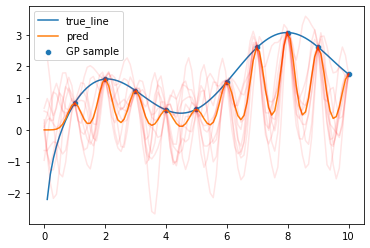

In [214]:
x = np.linspace(0,10,100)

gpx = np.linspace(1,10,10)
gpy = f(gpx)
k = kern(ls=.1)
m,cov = gp_predict(gpx,gpy,x,k)


sns.lineplot(x,f(x),label='true_line')
sns.lineplot(x,m,label='pred')

sns.scatterplot(gpx,gpy,label='GP sample')

realization = np.random.multivariate_normal(mean=m, cov=cov, size=100)
for i in range(10):
    sns.lineplot(x,realization[i,:],color='red',alpha=0.1)


# Kriging
- find the next best location to explore , given the data points 

In [14]:
import time 
def f(x,cost=0):
    time.sleep(cost)
    return np.log(x) + np.sin(x)



def krig(f,lower,upper,kern,nstep=10,exploration=.9,cost=0,gp_estimator = gp_predict):
    """
        find the maximum of *any* costly function with bayesian optimization
        strategy: evaluate f at some point, and use our assumption of how smooth the 
        function f is, find the next location that hopefully produce better result.
        
        the GP kernel control how smoothe we think the function is
        
        we also do not want to find and stick to a local minima, so exploration is encouraged
    
        params:
            f: the function to maximize
            lower, upper: float, range of our exploration

    """
    x = np.array([np.random.uniform(lower,upper)])
    y = np.array([])
    
    
    for step in range(nstep):
        _y = f(x[-1],cost=cost)
        y = np.concatenate([y,[f(x[-1],cost=cost)] ])
        seq = np.argsort(np.array(x))
    
        y = y[seq]
        x = x[seq]
        
        x2 = np.linspace(lower,upper,100)


        mean,cov  = gp_estimator(x, y, x2, kern)
        y2 = np.random.multivariate_normal(mean=mean, cov=cov, size=len(x2))

        for s in range(10):
            sns.lineplot(x2,y2[s,:],color='red',alpha=0.1)   
        sns.lineplot(x2,f(x2))
        sns.lineplot(x2,mean,color='orange')


        #which bin this point belong to 
        binloc = np.digitize(x2,x)

        agg = {b:[] for b in np.unique(binloc)}
        for i in range(len(y2)):
            for j,loc in enumerate(binloc):
                agg[loc] += y2[i,j],

        #choosing the bin by maximizing potential 
        vuong_dep_zai = partial(np.quantile,q=0.95)

        bin_potential = [(b,vuong_dep_zai(v) ) for b,v in agg.items()]
        best_bin,val = sorted(bin_potential,key=lambda _x:_x[1],reverse=True)[0]
        rand_bin = np.random.choice(list(agg.keys()))

        #exploration vs exploitation
        dest = rand_bin if np.random.uniform() < exploration else best_bin
        _x = [lower] + list(x) + [upper]
        new_location  = (_x[dest] + _x[dest+1]) / 2     
        
        #prevent GP from breaking with singular cov matrix
        if any([np.isclose(new_location,i,0.01) for i in x]): 
            new_location  = (_x[rand_bin] + _x[rand_bin+1]) / 2  
            
        x = np.concatenate([x,[new_location]])


        plt.axvline(new_location,color='green',label='next_location',alpha=0.3)
        plt.show()        




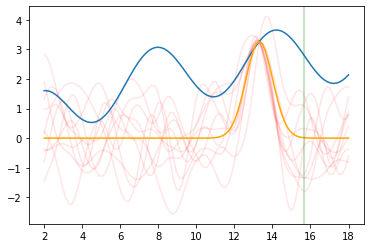

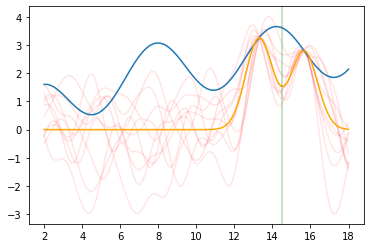

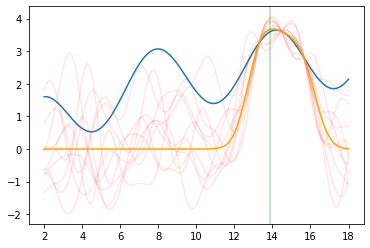

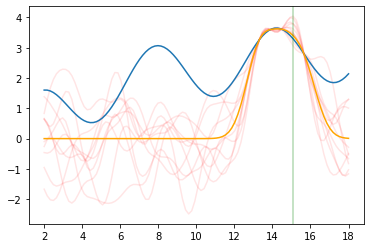

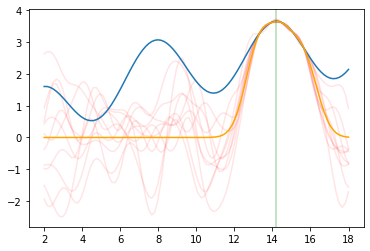

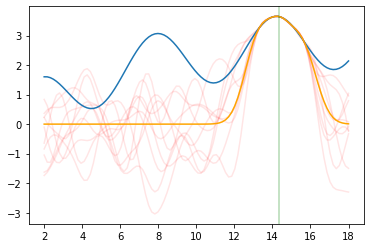

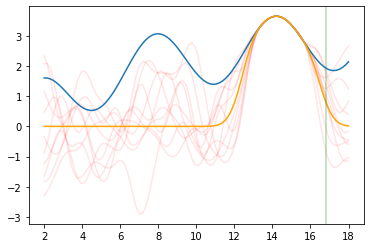

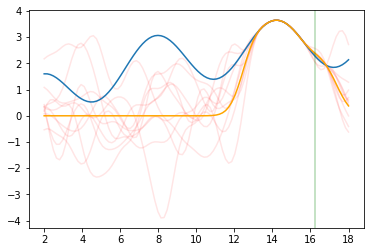

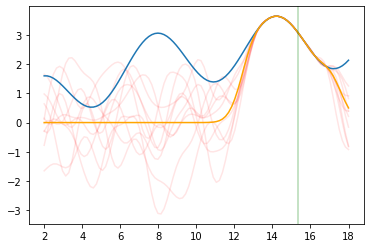

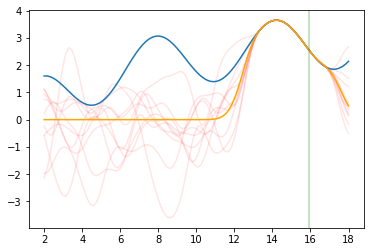

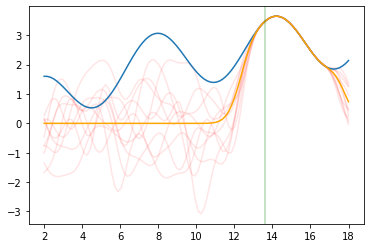

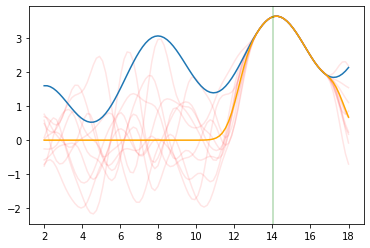

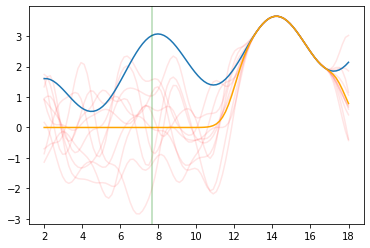

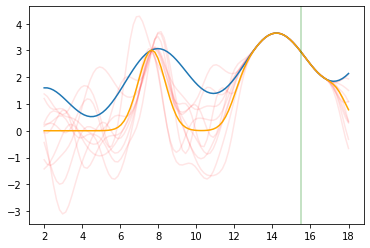

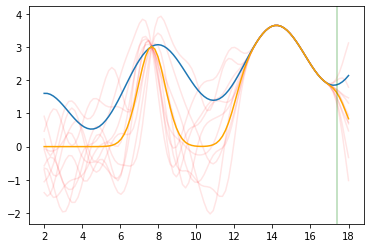

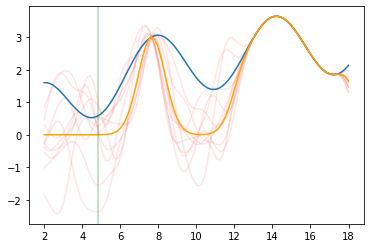

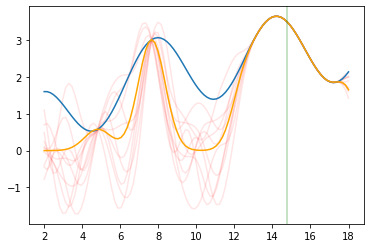

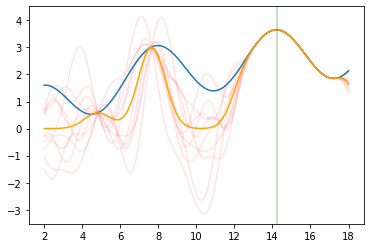

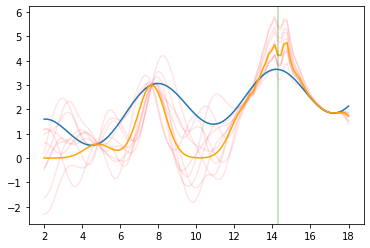

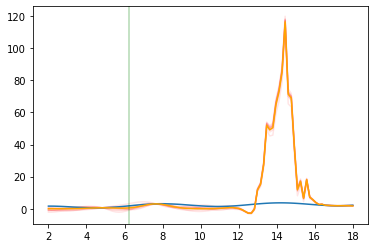

In [15]:
#set exploration to 0.1 to exploit the current values most of the time 
k = kern(ls=1)
a = krig(f,2,18,k,nstep=20,exploration=0.1,cost=0)

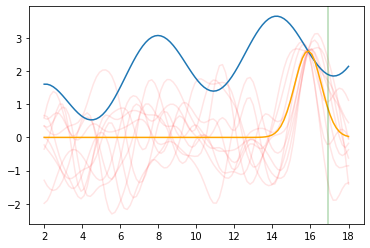

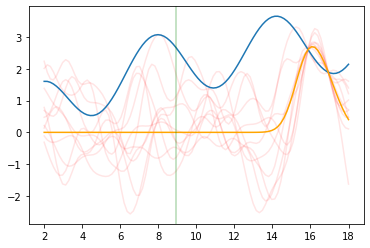

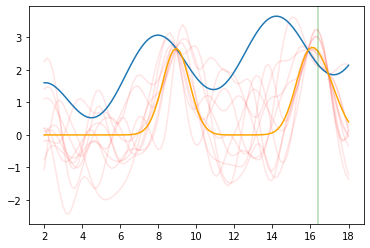

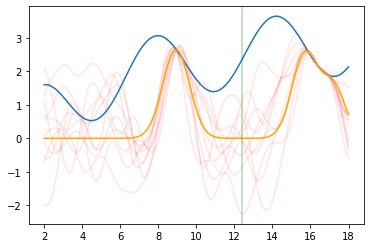

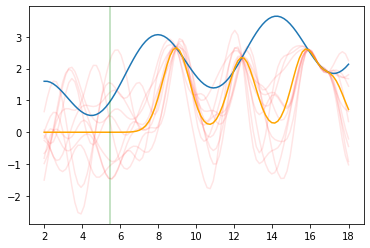

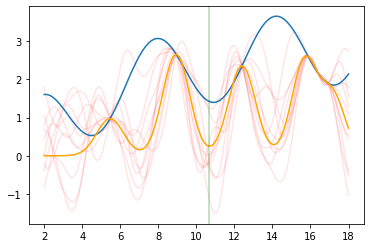

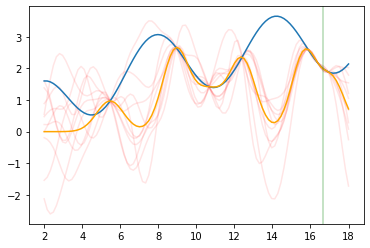

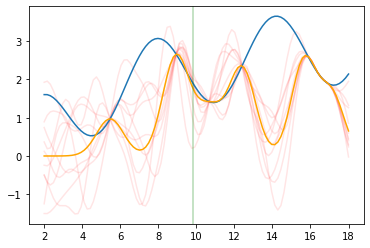

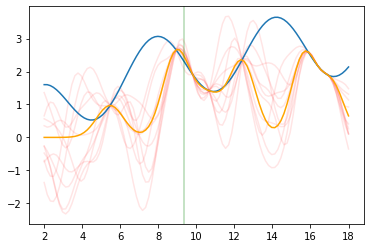

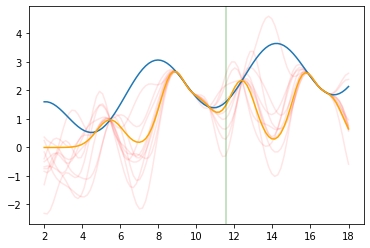

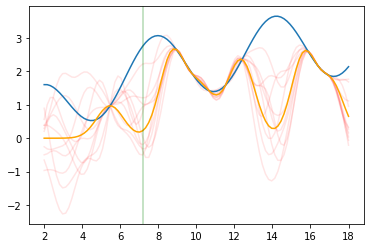

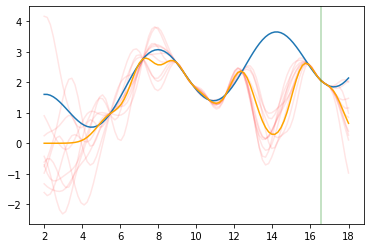

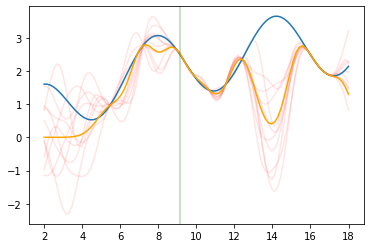

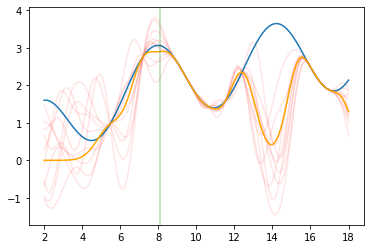

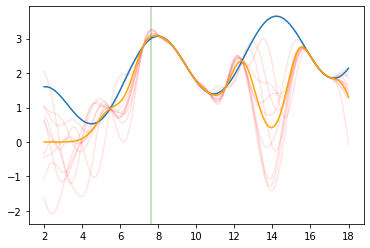

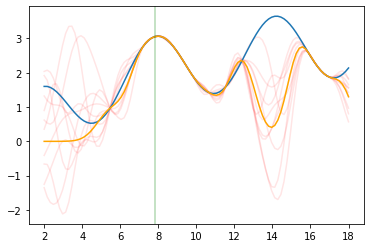

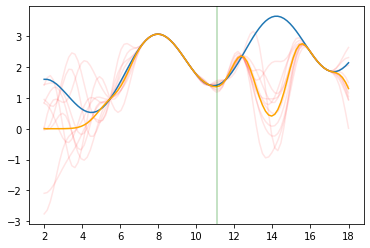

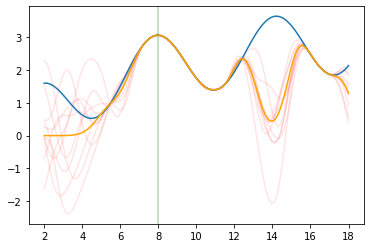

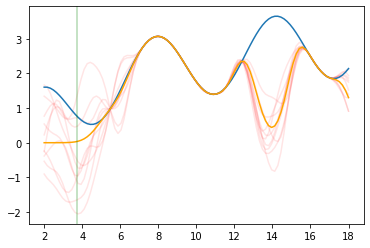

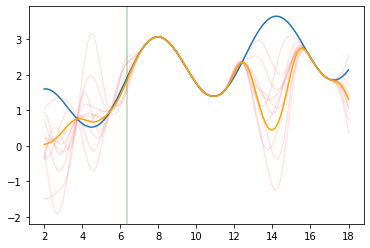

In [16]:
#set exploration to 0.1 to exploit the current values most of the time 
k = kern(ls=1)
a = krig(f,2,18,k,nstep=20,exploration=0.5,cost=0)

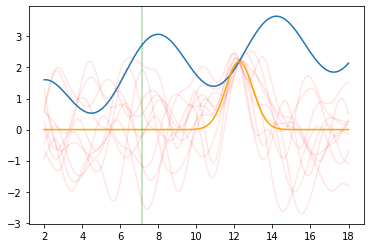

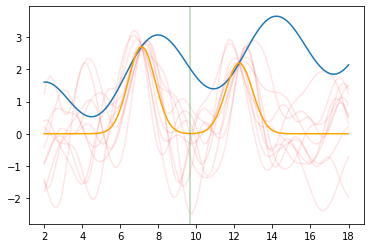

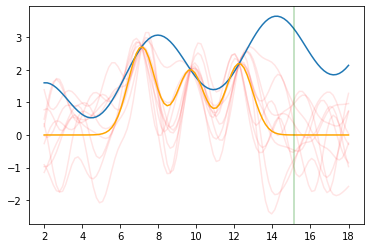

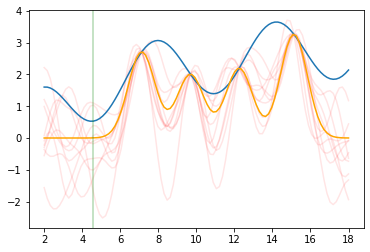

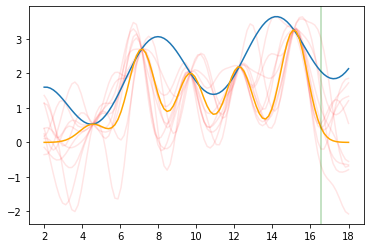

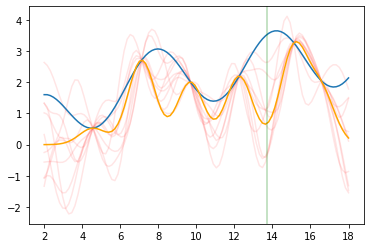

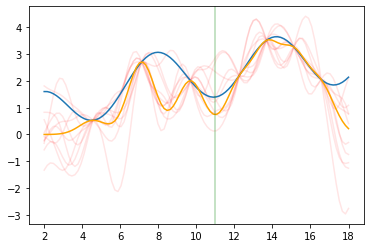

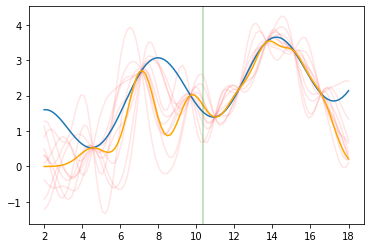

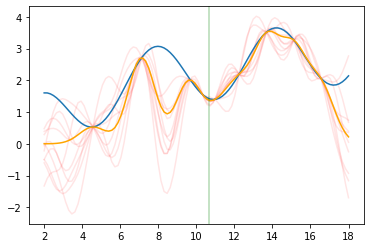

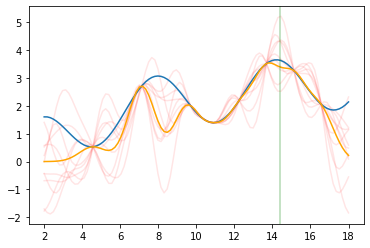

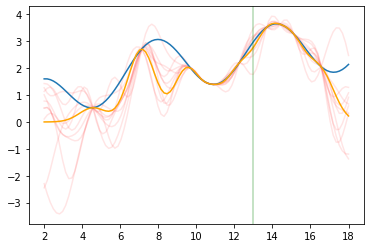

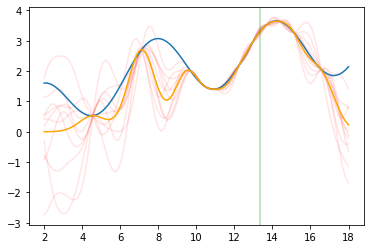

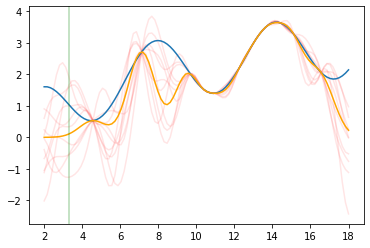

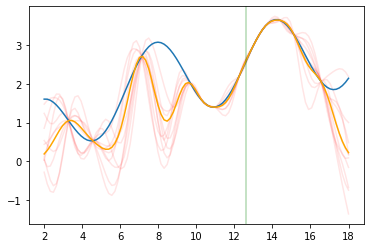

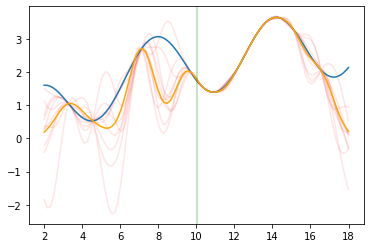

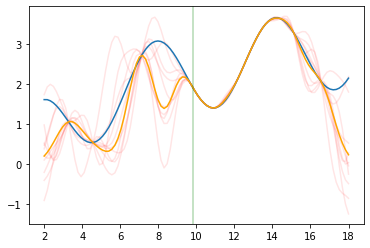

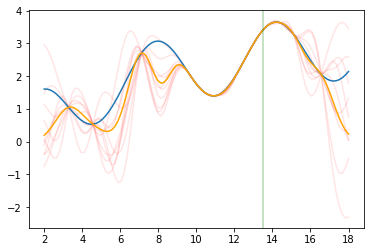

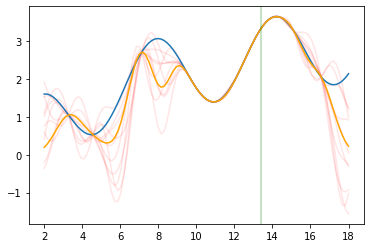

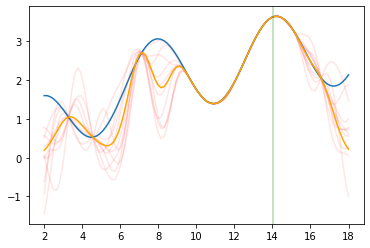

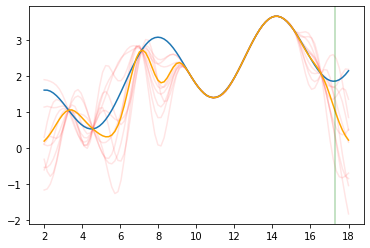

In [17]:
#set exploration to 0.1 to exploit the current values most of the time 
k = kern(ls=1)
a = krig(f,2,18,k,nstep=20,exploration=0.9,cost=0)

In [18]:
#adding noise to the Kernel estimate to reflect the level of accuracy of our measurement

In [19]:


def gp_noise(x1,y1,x2,kern,noise=0.01):
    assert len(x1) == len(y1)
    #make it more stable for numerical optim
    k11 = kern(x1,x1) + np.random.normal(0,noise**2,size=len(x1)) * np.eye(len(x1))
    
    y2 = kern(x2,x1) @ np.linalg.inv(k11) @ y1
    covy2 = kern(x2,x2) - kern(x2,x1) @ np.linalg.inv(k11) @ kern(x1,x2)
    return y2, covy2


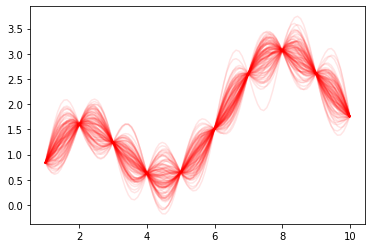

In [20]:
x1 = np.linspace(1,10,10)
x2 = np.linspace(1,10,100)

m,sig  = gp_noise(x1,f(x1),x2,kern(ls=1))

y2 = np.random.multivariate_normal(mean=m, cov=sig, size=100)
for i in range(len(y2)):
    sns.lineplot(x2,y2[i,:],color='red',alpha=0.1)

In [21]:
gpnoise_estimator = partial(gp_noise,noise=0.5)

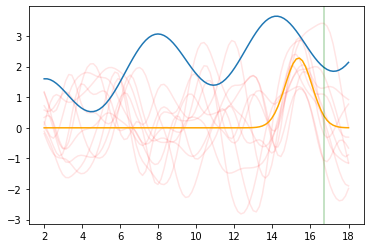

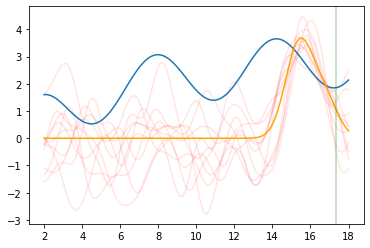

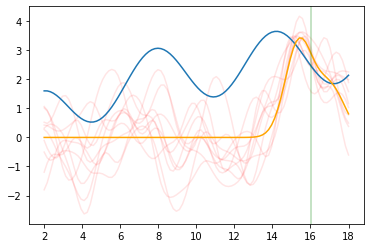

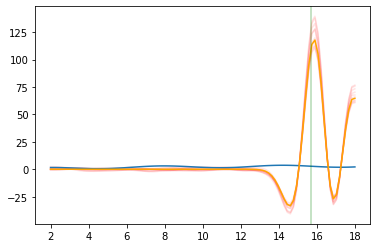

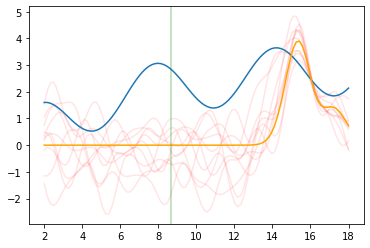

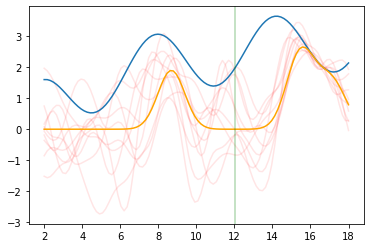

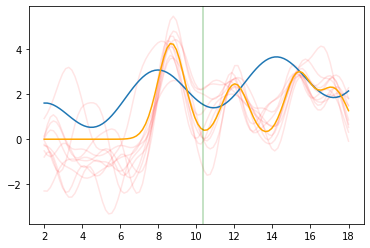

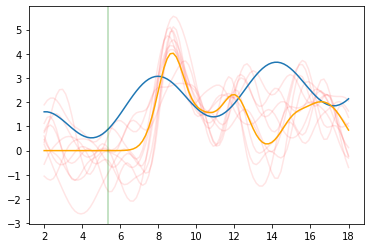

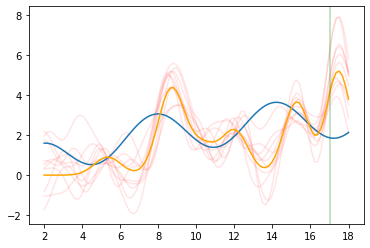

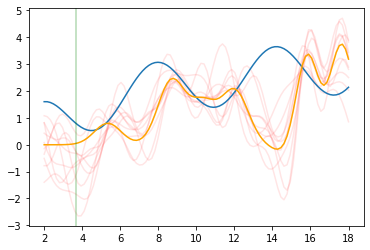

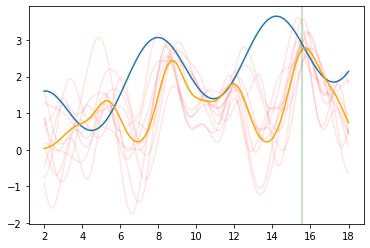

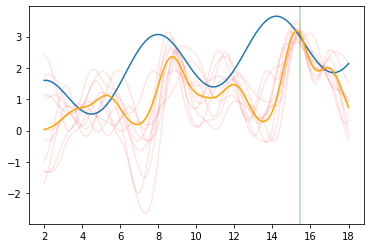

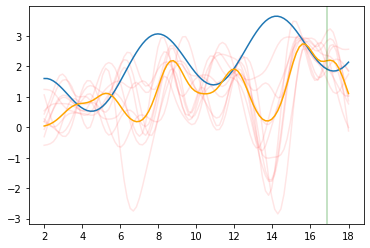

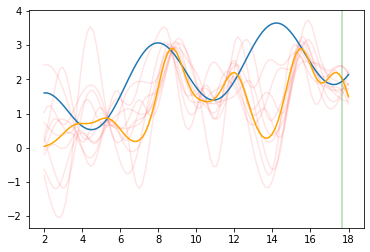

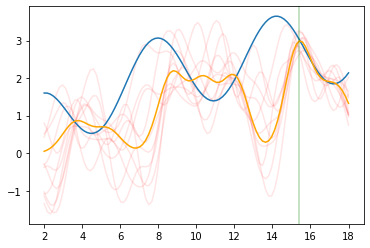

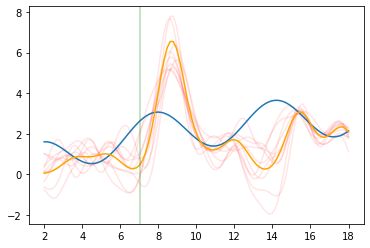

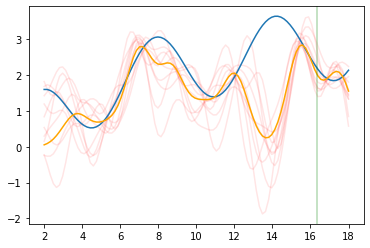

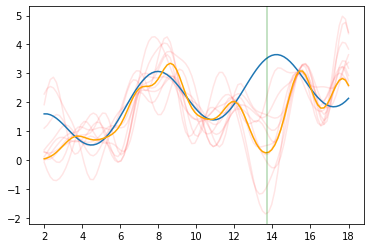

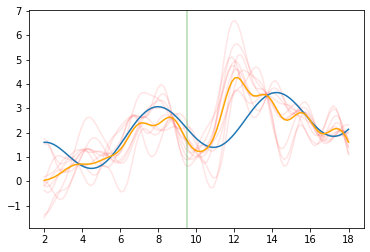

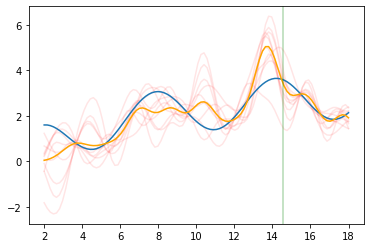

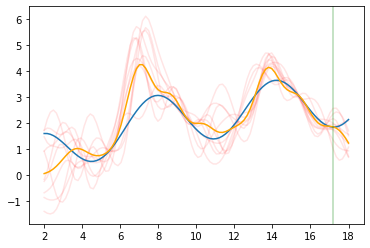

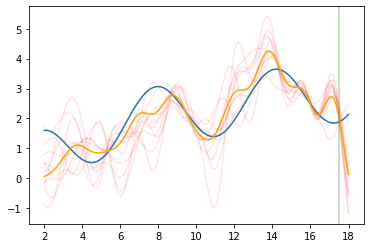

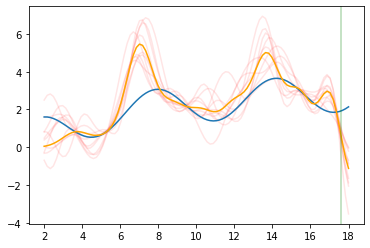

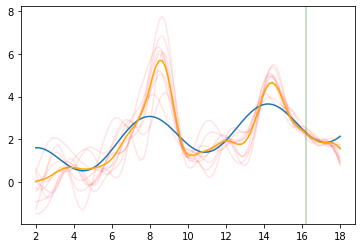

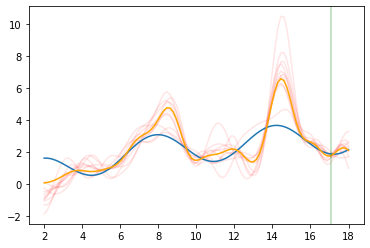

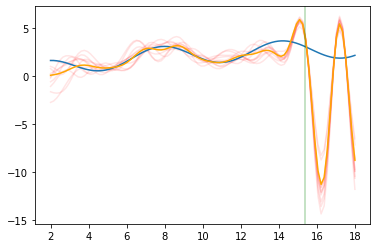

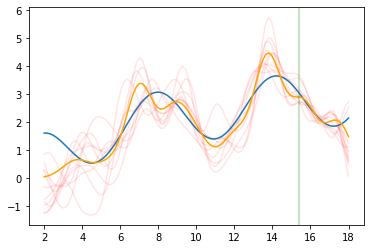

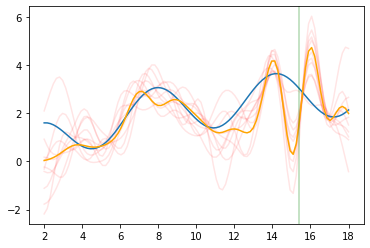

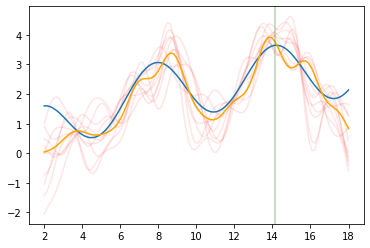

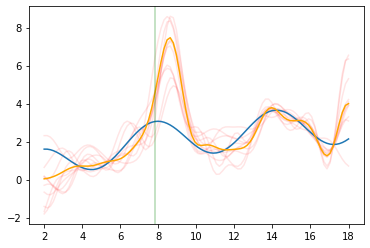

In [22]:
a = krig(f,2,18,kern(ls=1),nstep=30,exploration=0.99,gp_estimator=gpnoise_estimator)

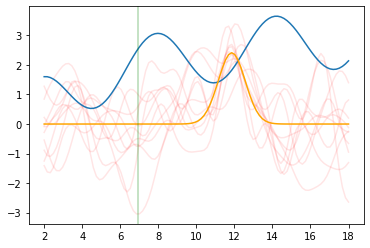

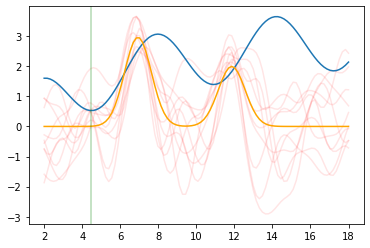

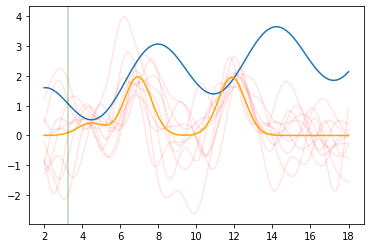

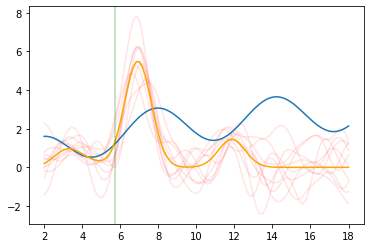

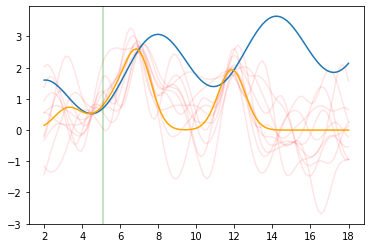

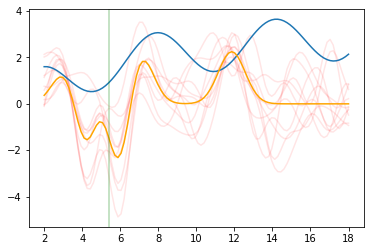

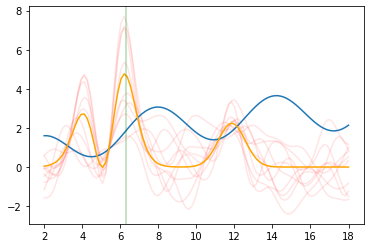

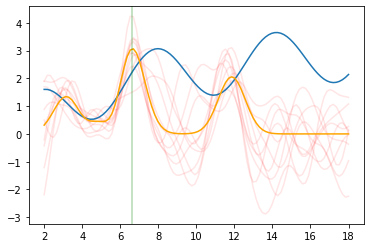

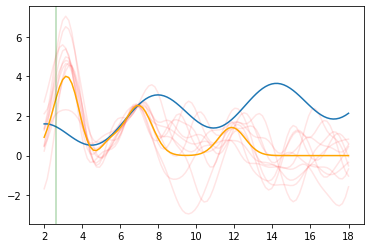

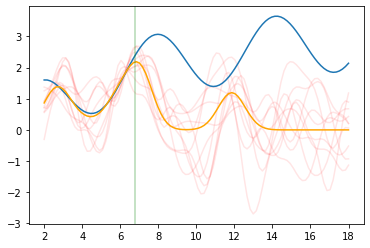

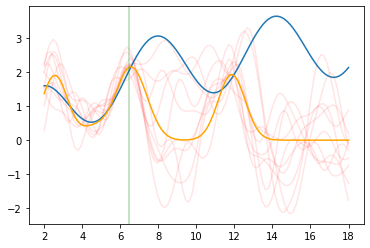

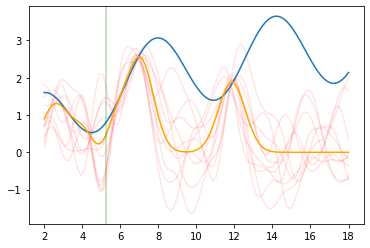

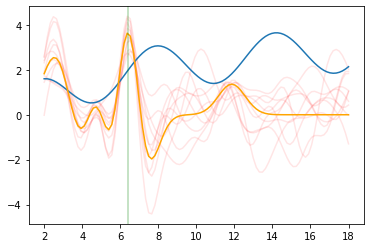

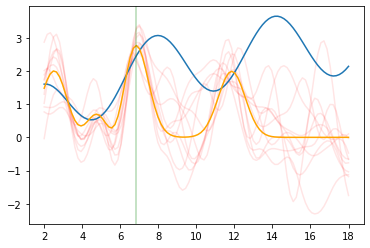

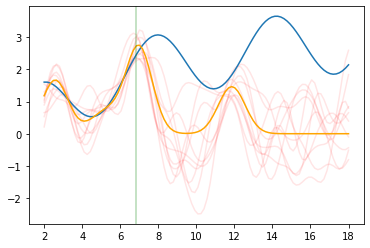

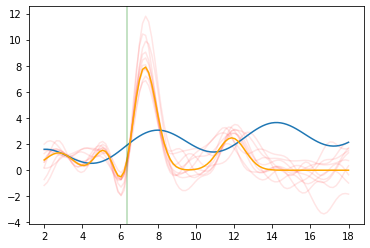

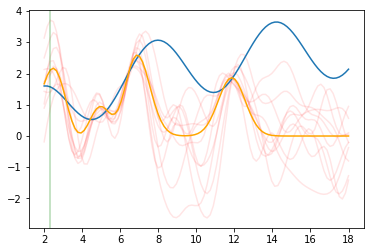

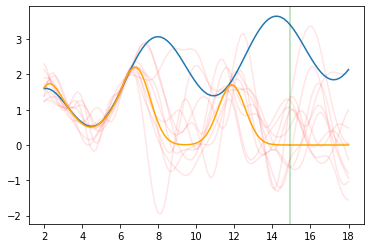

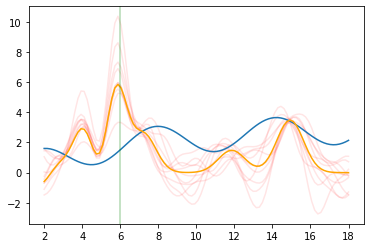

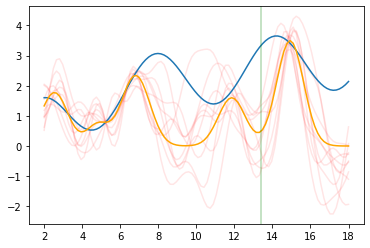

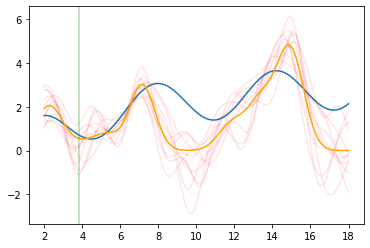

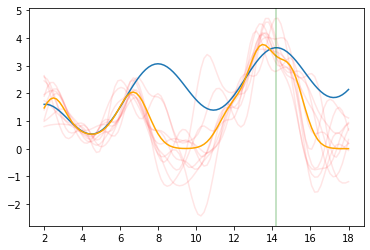

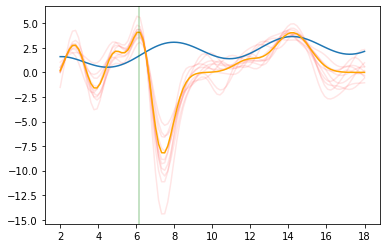

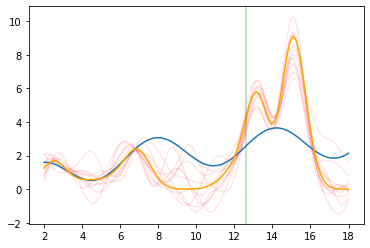

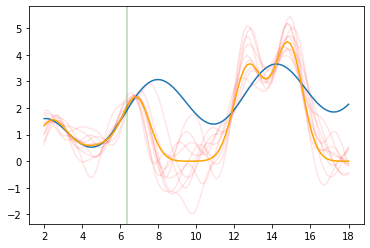

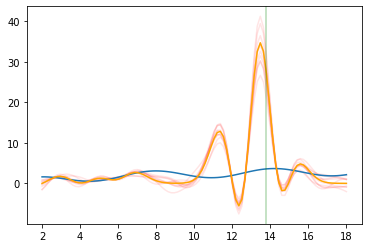

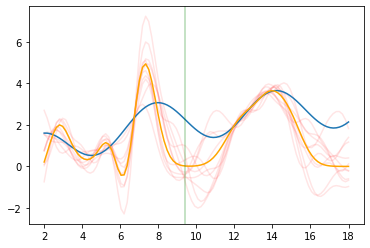

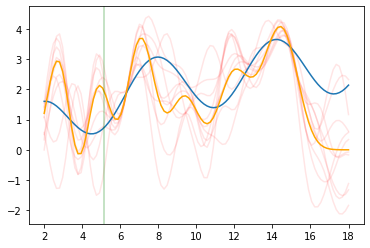

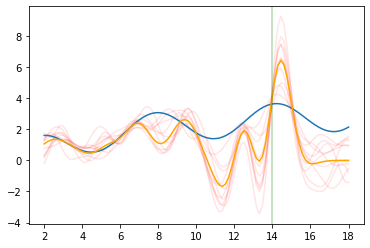

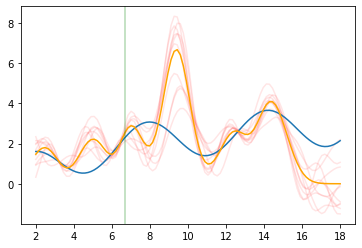

In [23]:
a = krig(f,2,18,kern(ls=1),nstep=30,exploration=0.5,gp_estimator=gpnoise_estimator)

# Linear smoother 

<AxesSubplot:>

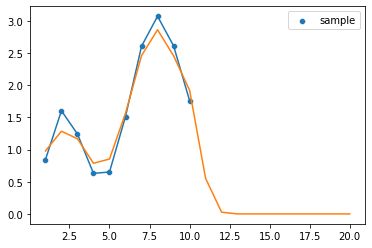

In [286]:
def _rbf(x1,x2,ls=1.):
    return np.exp(-(x1-x2)**2 / ls)

def linear_smoother(x1,y1,x2):
    # Nadaraya-Watson estimator predictor generate prediction for a single point
    
    weights = np.array([_rbf(x2,i) for i in x1])
    weights = weights/weights.sum()
    return np.sum(y1*weights)
def _rbf(x1,x2,ls=1.):
    return np.exp(-(x1-x2)**2 / ls)

def linear_smoother(x1,y1,x2):
    # Nadaraya-Watson estimator predictor generate prediction for a single point
    
    weights = np.array([_rbf(x2,i) for i in x1])
    
    #linear smoother weight 
#     weights = weights/weights.sum()
    
    #GP weight 
    weights = weights * np.linalg.inv(rbf(x1,x1))
        
    return np.sum(y1*weights)
x1 = np.linspace(1,10,10)
x2 = np.linspace(1,20,20)


sns.scatterplot(x1,f(x1),label='sample')
sns.lineplot(x1,f(x1))

pred  = [linear_smoother(x1,f(x1),i) for i in x2]
sns.lineplot(x2,pred)
#see the mean level does not go to zero as with GP, it stuck with the last value it sees

# Some interesting kernels

In [4]:
from sklearn.gaussian_process.kernels import *

## standard kernels 

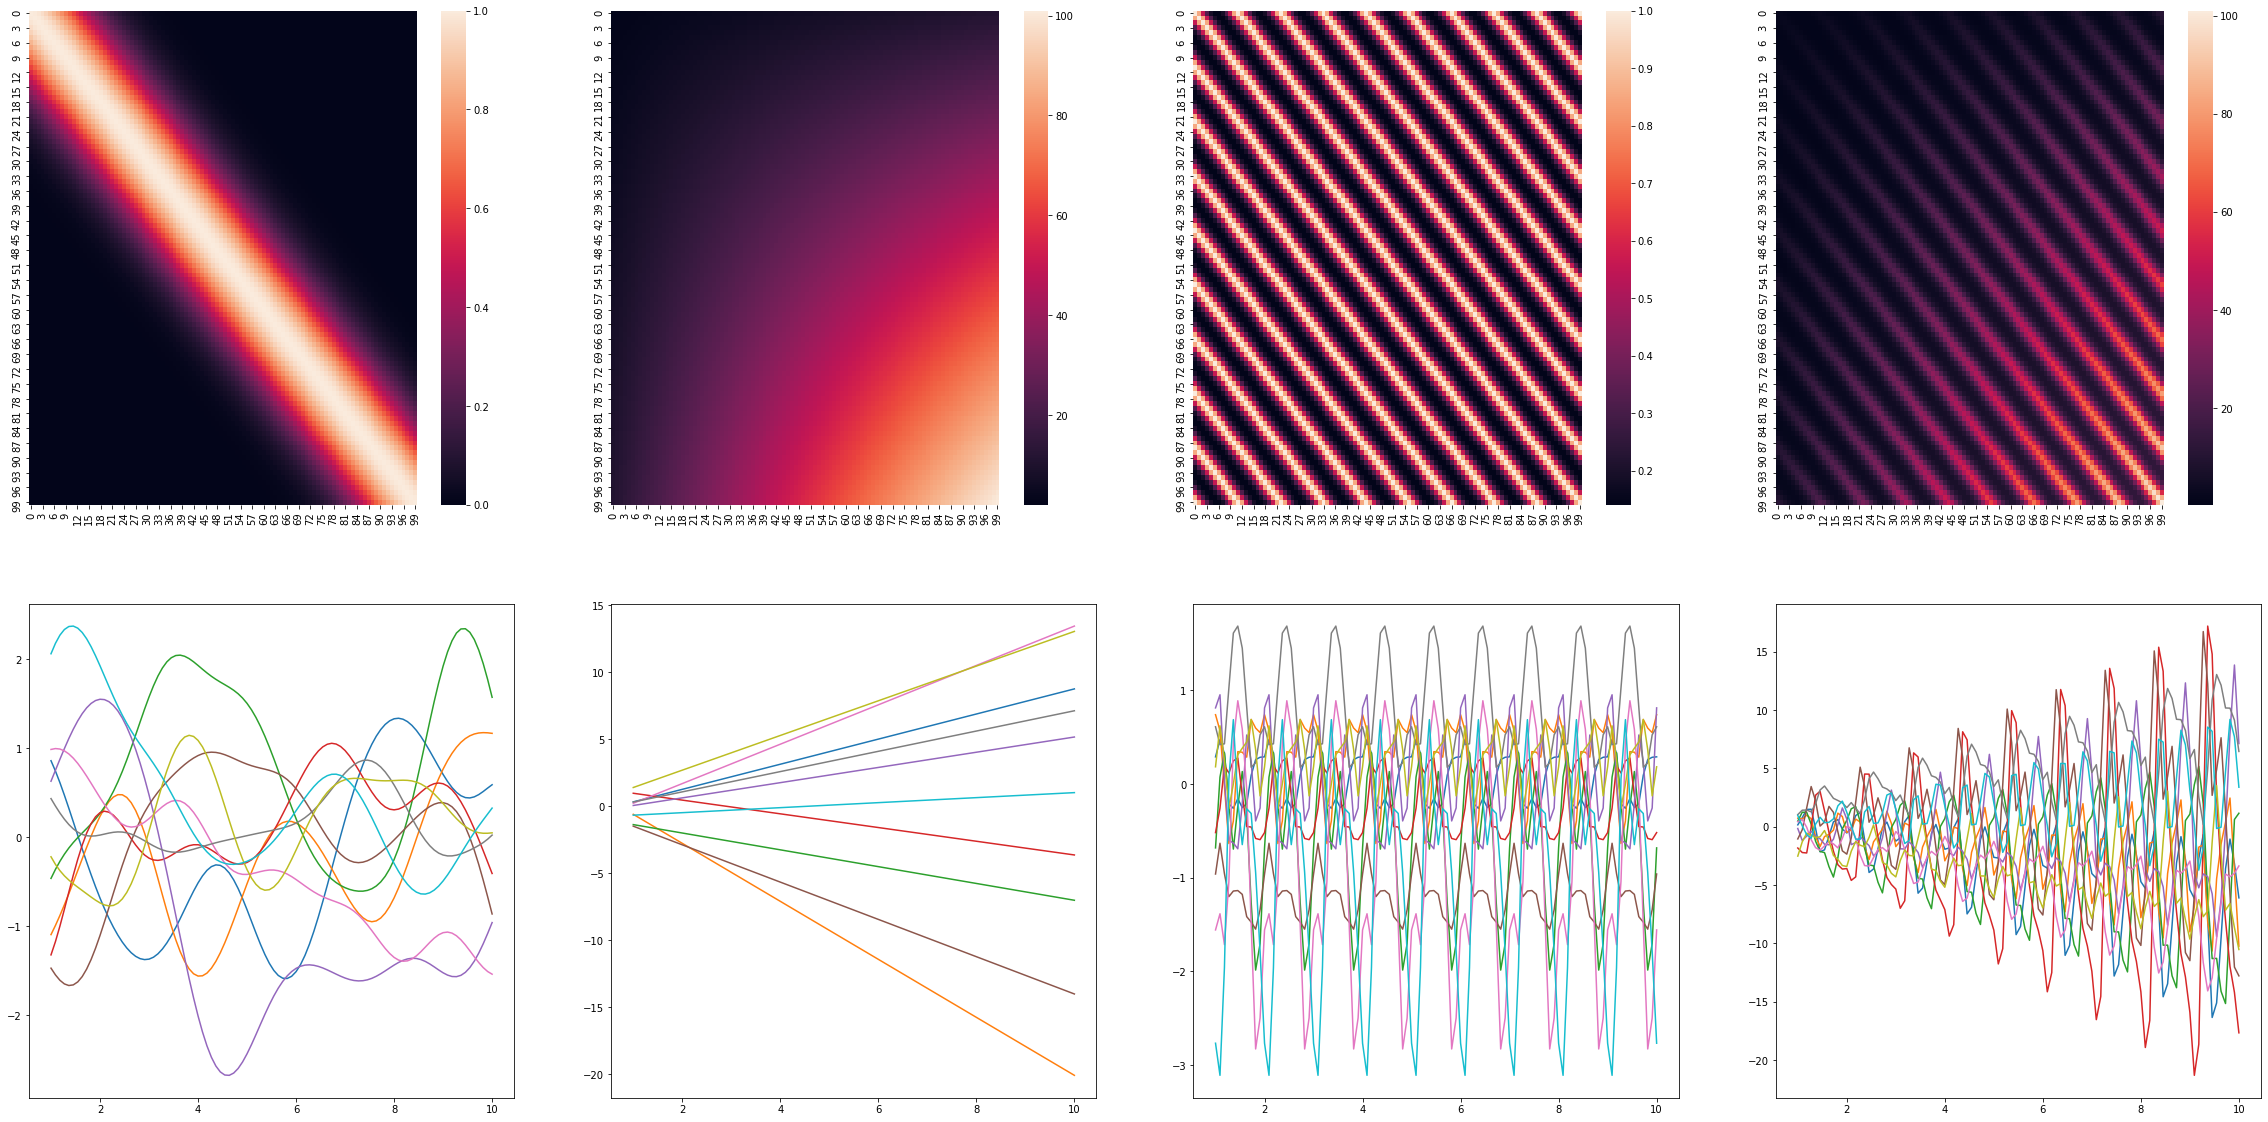

In [15]:
x = np.linspace(1,10,100)

kernels = [RBF(1),DotProduct(1),ExpSineSquared(1)]
nplots = len(kernels)
plt.figure(figsize=(nplots*10,20))

#change this to see effects of length scale on output 
for i,k in enumerate(kernels):
    plt.subplot(2,nplots,i+1)
    cov  = k.__call__(x.reshape(-1,1),x.reshape(-1,1))
    sns.heatmap(cov)


    #draw some realization  from the Gaussian process
    y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=10)
    plt.subplot(2,nplots,nplots+i+1)
    for j in range(len(y)):
        sns.lineplot(x,y[j,:])


## kernels combinations 

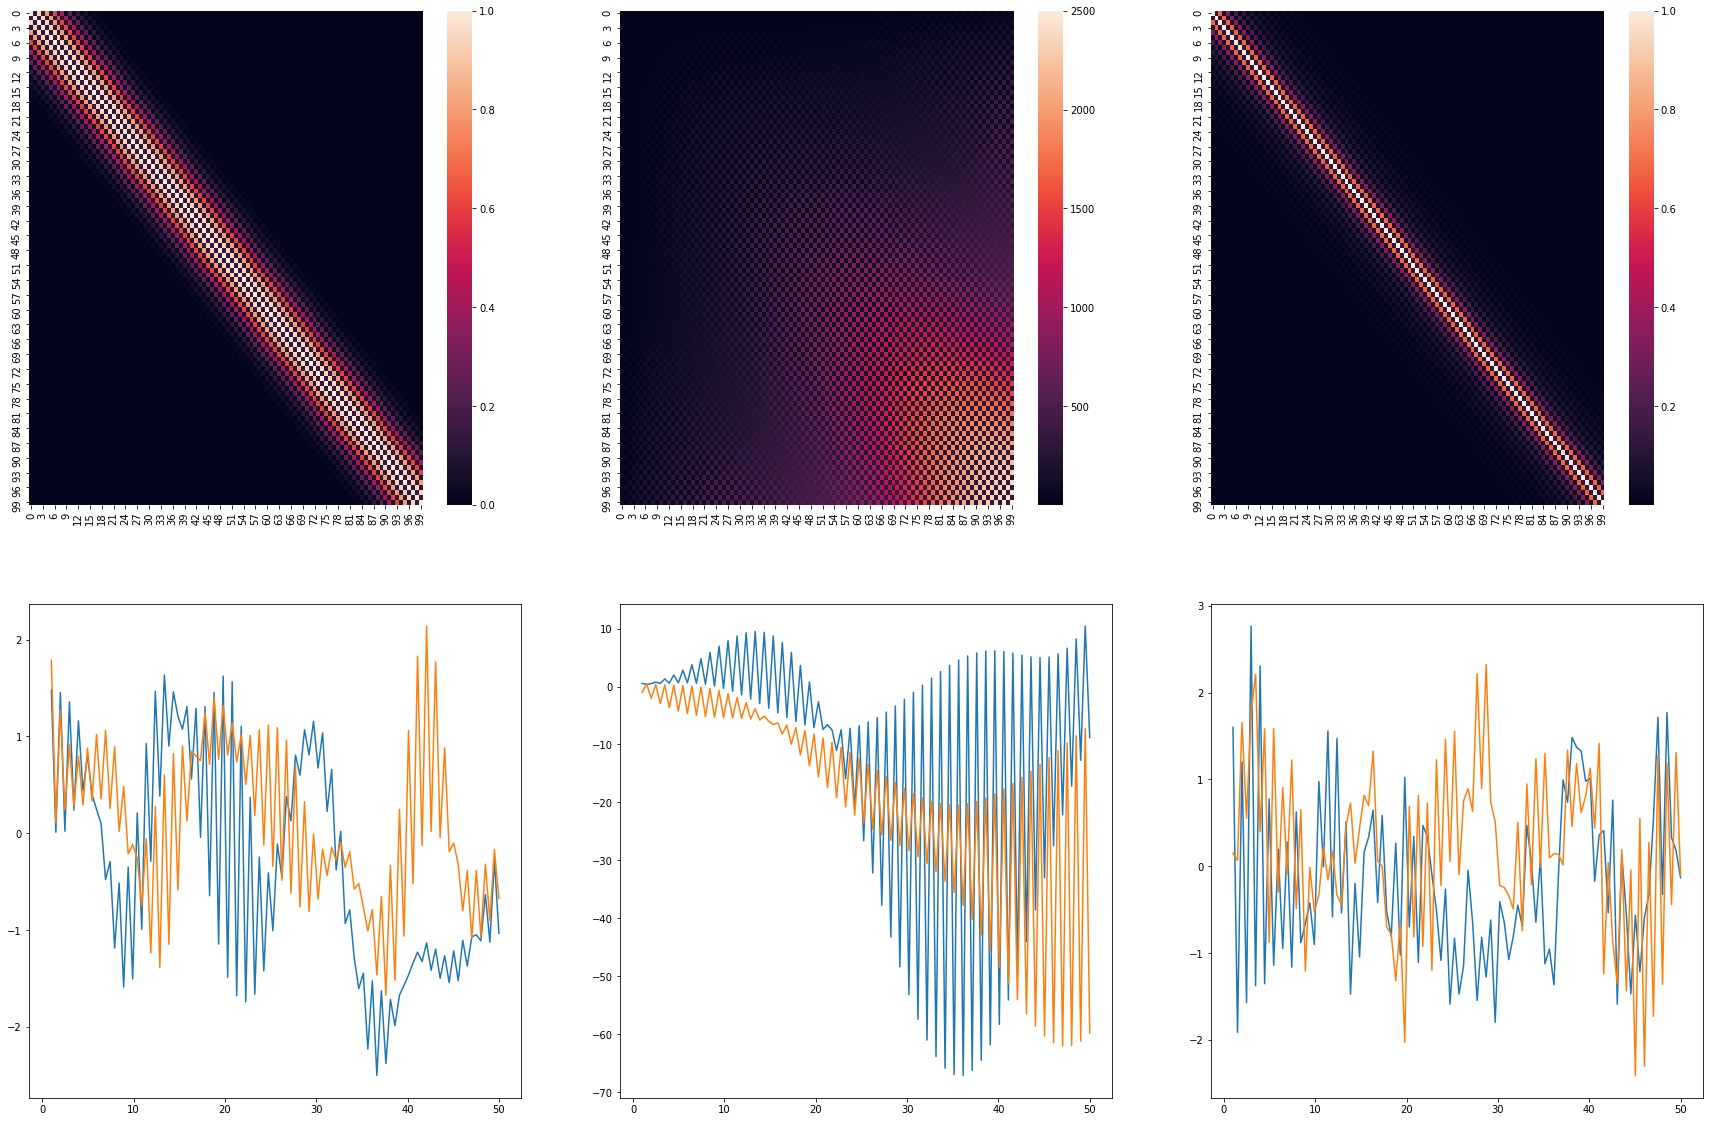

In [25]:
x = np.linspace(1,50,100)

kernels = [ExpSineSquared() * RBF(3), 
           ExpSineSquared() * DotProduct(1),
           ExpSineSquared(1)* RationalQuadratic(1)]
nplots = len(kernels)
plt.figure(figsize=(nplots*10,20))

#change this to see effects of length scale on output 
for i,k in enumerate(kernels):
    plt.subplot(2,nplots,i+1)
    cov  = k.__call__(x.reshape(-1,1),x.reshape(-1,1))
    sns.heatmap(cov)


    #draw some realization  from the Gaussian process
    y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=2)
    plt.subplot(2,nplots,nplots+i+1)
    for j in range(len(y)):
        sns.lineplot(x,y[j,:])


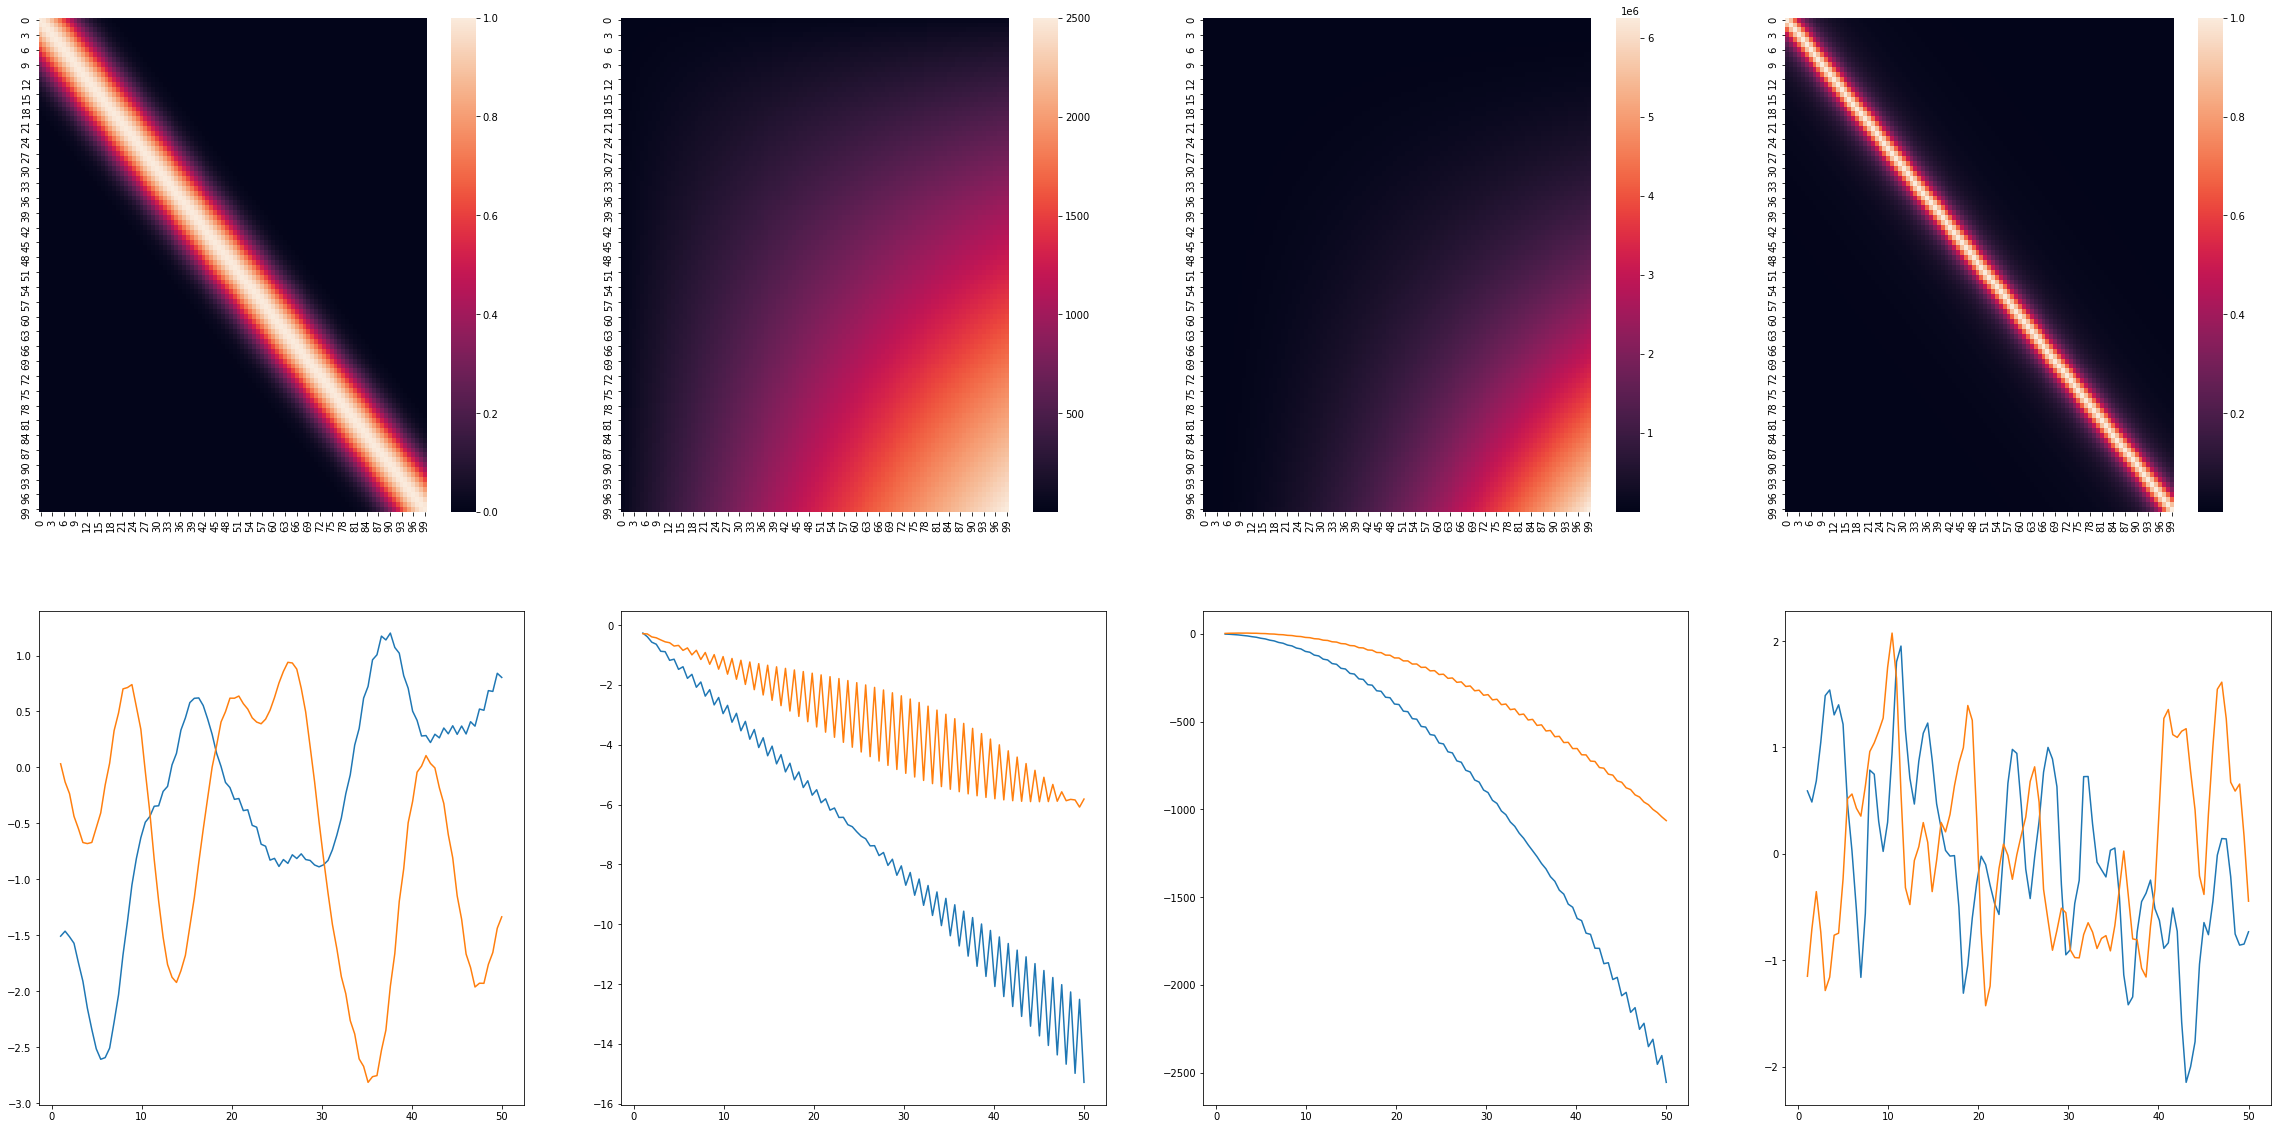

In [61]:
x = np.linspace(1,50,100)

kernels = [ExpSineSquared(50) * RBF(3), 
           ExpSineSquared(50) * DotProduct(1),
           ExpSineSquared(50) * DotProduct()**2,
           ExpSineSquared(50)* RationalQuadratic(1)]
nplots = len(kernels)
plt.figure(figsize=(nplots*10,20))

#change this to see effects of length scale on output 
for i,k in enumerate(kernels):
    plt.subplot(2,nplots,i+1)
    cov  = k.__call__(x.reshape(-1,1),x.reshape(-1,1))
    sns.heatmap(cov)


    #draw some realization  from the Gaussian process
    y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=2)
    plt.subplot(2,nplots,nplots+i+1)
    for j in range(len(y)):
        sns.lineplot(x,y[j,:])


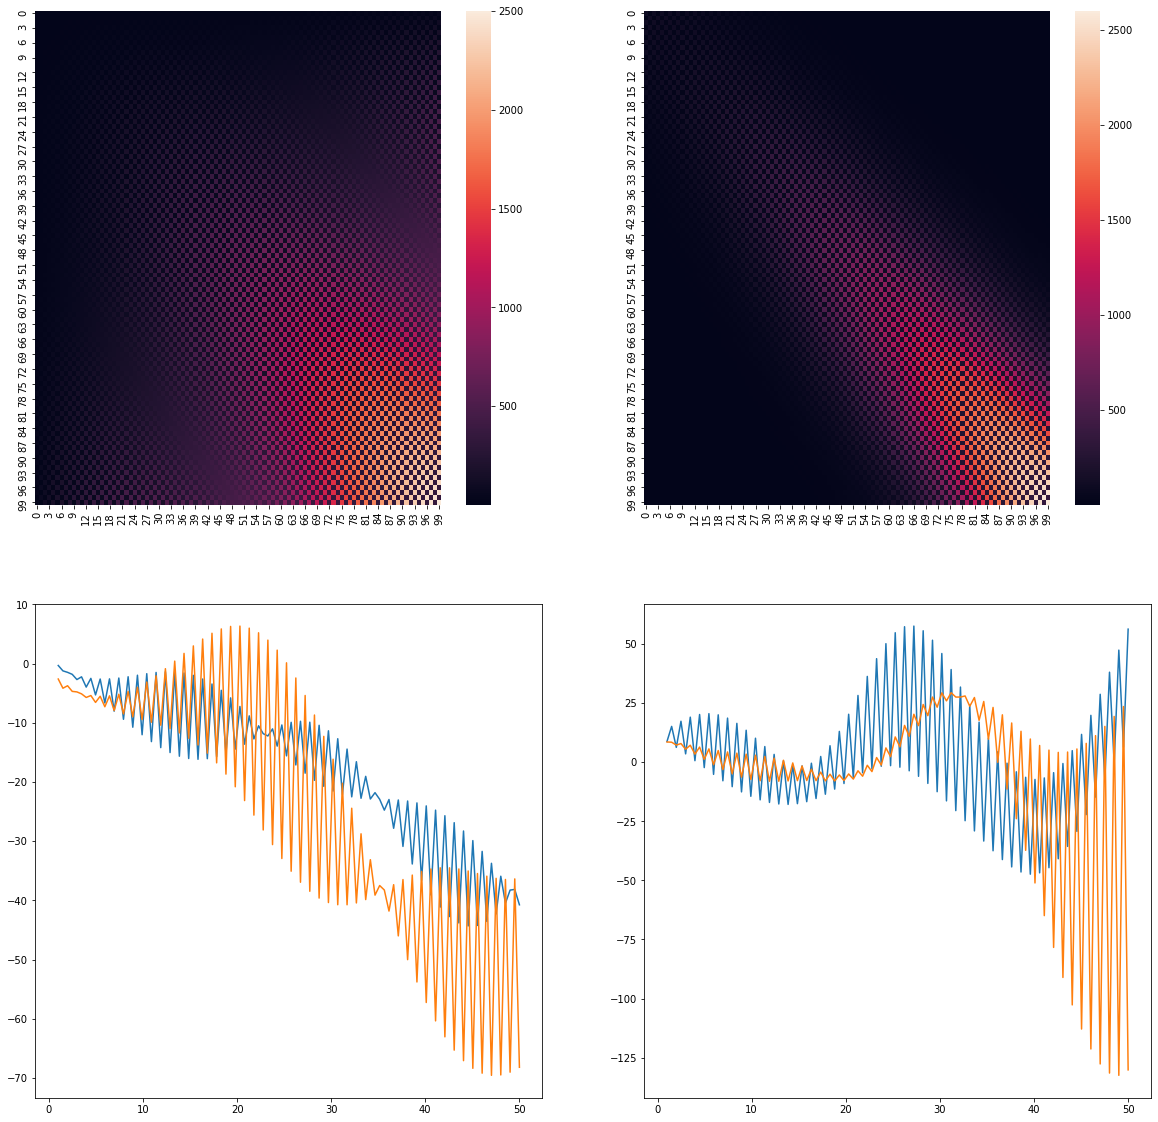

In [48]:
x = np.linspace(1,50,100)

kernels = [
            RBF(10) + DotProduct(1) * ExpSineSquared(),
            RBF(10) * DotProduct(10) * ExpSineSquared() ,
           
           ]
nplots = len(kernels)
plt.figure(figsize=(nplots*10,20))

#change this to see effects of length scale on output 
for i,k in enumerate(kernels):
    plt.subplot(2,nplots,i+1)
    cov  = k.__call__(x.reshape(-1,1),x.reshape(-1,1))
    sns.heatmap(cov)


    #draw some realization  from the Gaussian process
    y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=2)
    plt.subplot(2,nplots,nplots+i+1)
    for j in range(len(y)):
        sns.lineplot(x,y[j,:])


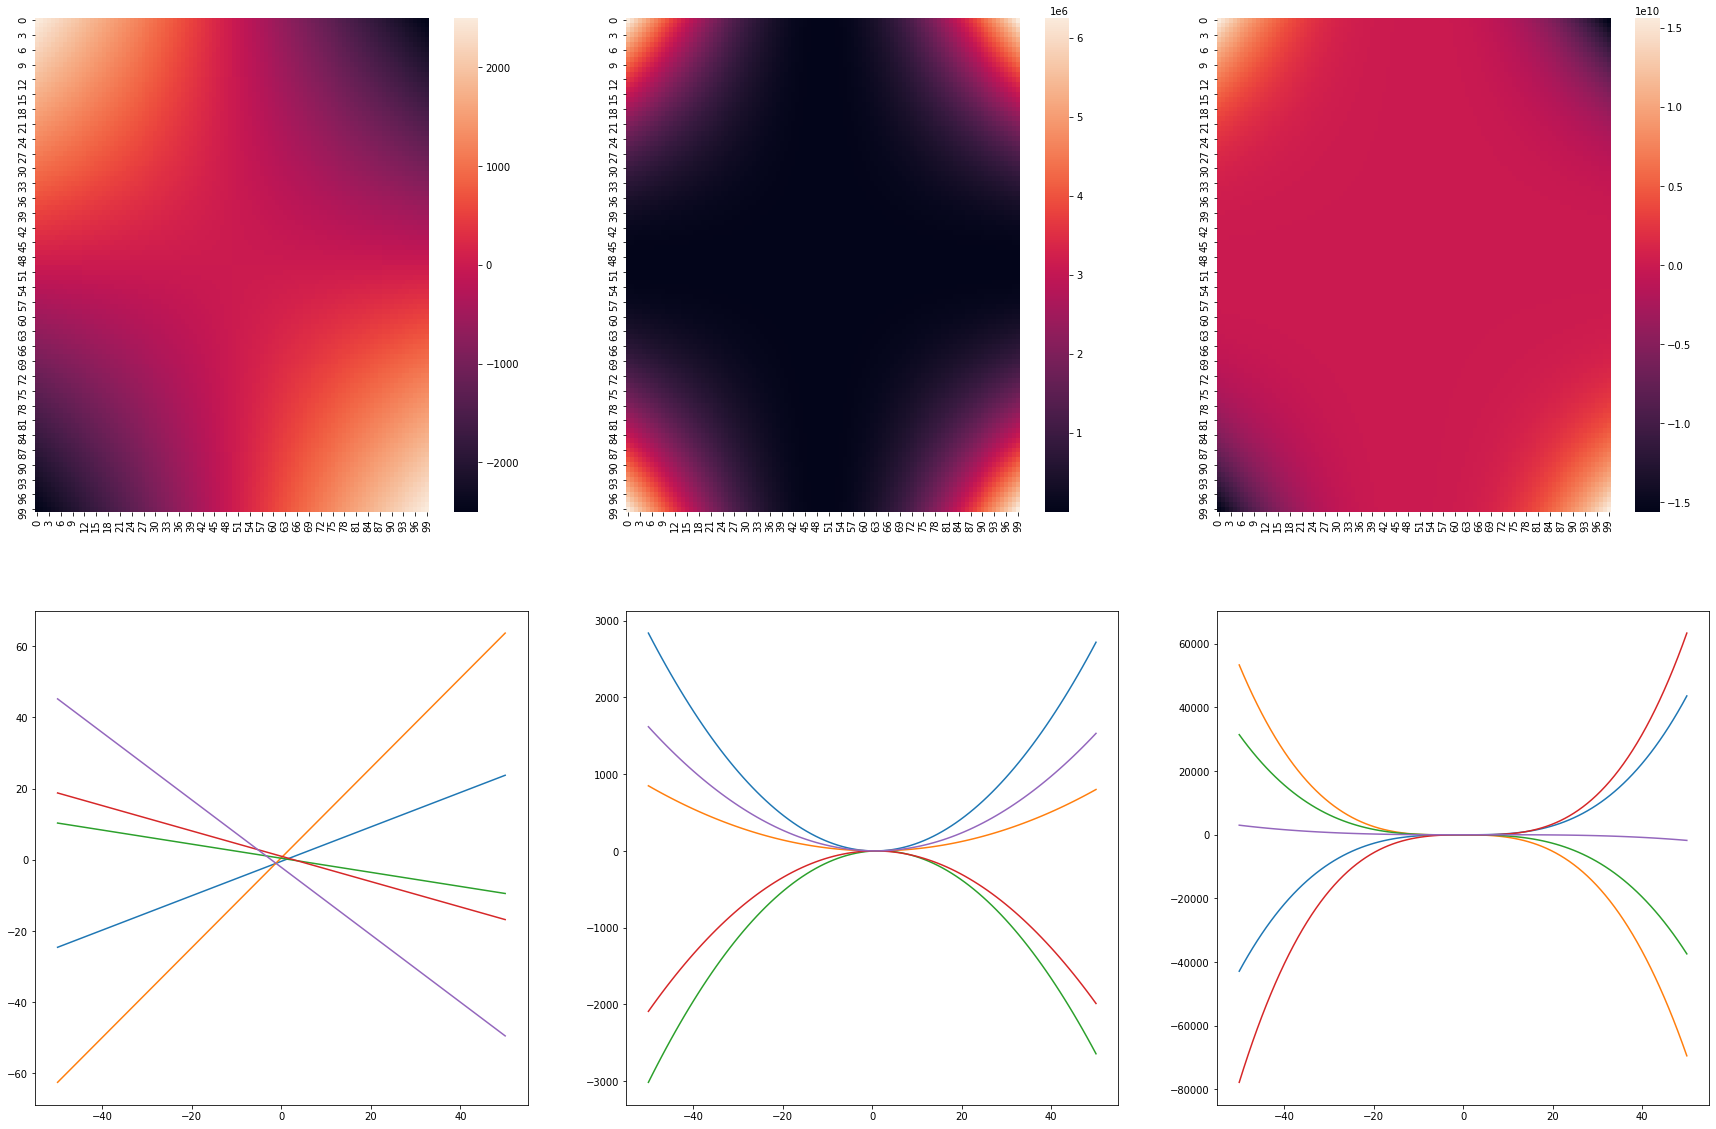

In [59]:
x = np.linspace(-50,50,100)

kernels = [
            DotProduct() ,
            DotProduct()**2,
            DotProduct()**3            
           ]
nplots = len(kernels)
plt.figure(figsize=(nplots*10,20))

#change this to see effects of length scale on output 
for i,k in enumerate(kernels):
    plt.subplot(2,nplots,i+1)
    cov  = k.__call__(x.reshape(-1,1),x.reshape(-1,1))
    sns.heatmap(cov)


    #draw some realization  from the Gaussian process
    y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=5)
    plt.subplot(2,nplots,nplots+i+1)
    for j in range(len(y)):
        sns.lineplot(x,y[j,:])


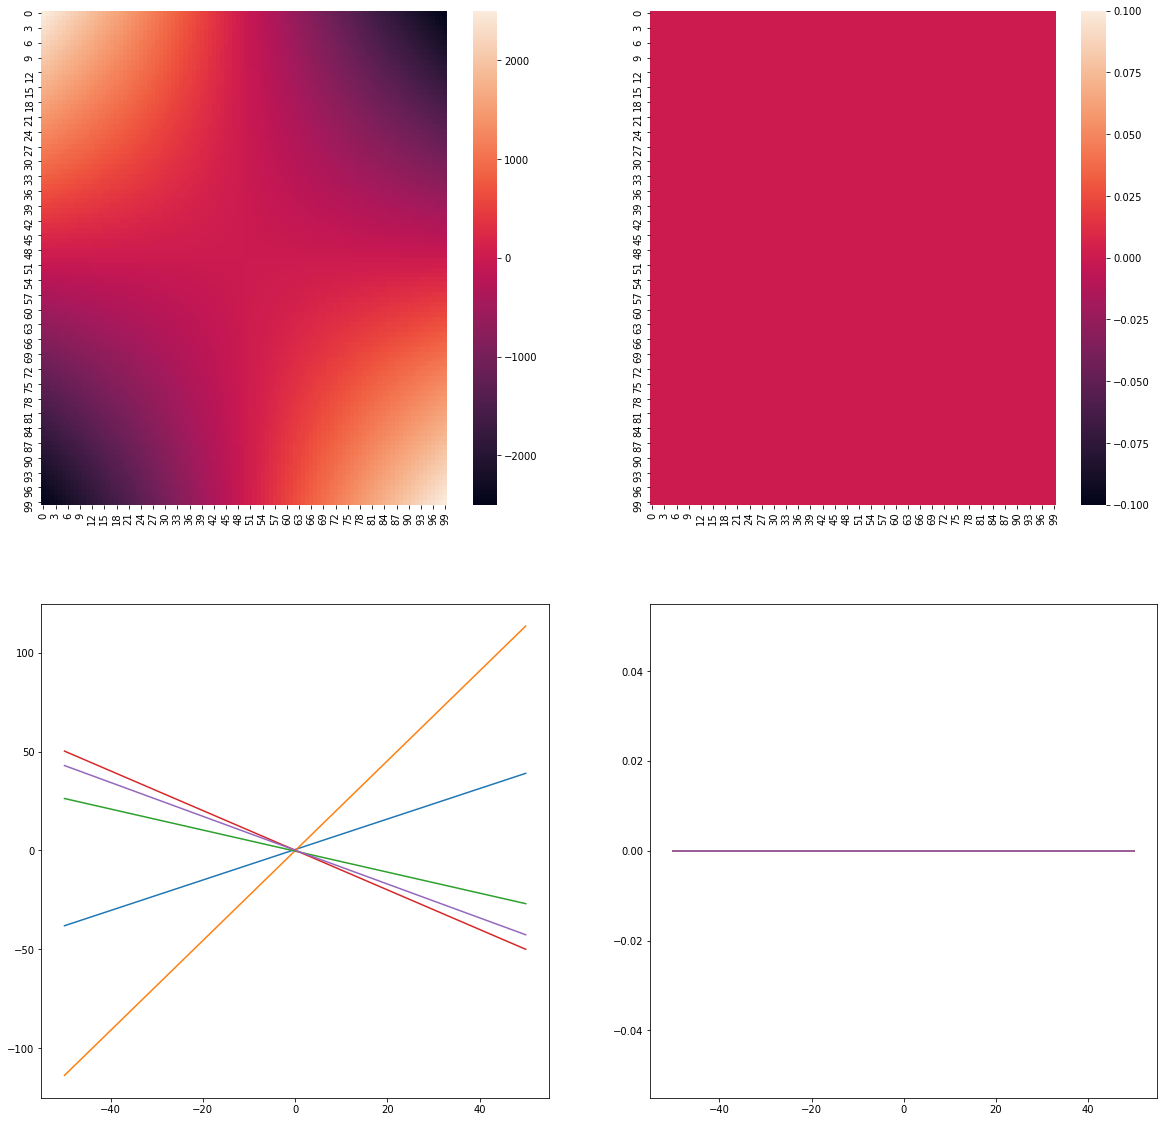

In [65]:
x = np.linspace(-50,50,100)

kernels = [
            DotProduct() ,
            DotProduct()* WhiteKernel(noise_level=5),
           ]
nplots = len(kernels)
plt.figure(figsize=(nplots*10,20))

#change this to see effects of length scale on output 
for i,k in enumerate(kernels):
    plt.subplot(2,nplots,i+1)
    cov  = k.__call__(x.reshape(-1,1),x.reshape(-1,1))
    sns.heatmap(cov)


    #draw some realization  from the Gaussian process
    y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=5)
    plt.subplot(2,nplots,nplots+i+1)
    for j in range(len(y)):
        sns.lineplot(x,y[j,:])


# Sigmoid kernel

In [81]:
def sigmoid(x,loc=0,scale=1,slope=1):
    x = x - loc
    return  scale / (1 +  np.exp(-x * slope))


<AxesSubplot:>

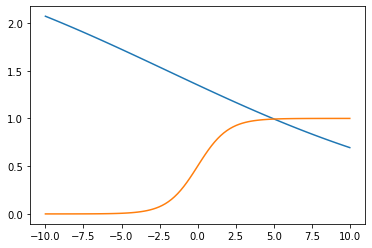

In [104]:
xplot = np.linspace(-10,10,100)
y = sigmoid(xplot,slope=-0.1,scale=3,loc=-2)
sns.lineplot(xplot,y)

y = sigmoid(xplot)
sns.lineplot(xplot,y)


<AxesSubplot:>

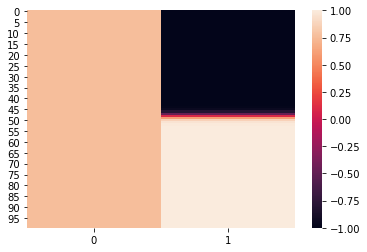

In [107]:
sk= PairwiseKernel(metric='sigmoid')
cov = sk.__call__(xplot.reshape(-1,1),np.array([-0,3]).reshape(-1,1))
sns.heatmap(cov)

In [112]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import sigmoid_kernel

<AxesSubplot:>

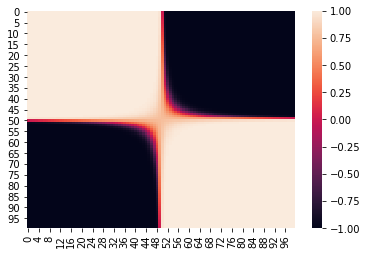

In [115]:
sns.heatmap(sigmoid_kernel(xplot.reshape(-1,1)))

<AxesSubplot:>

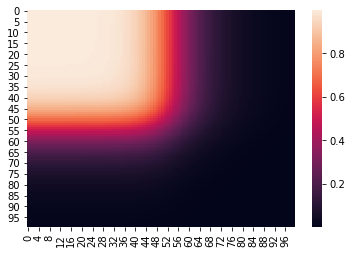

In [203]:
xs = np.sqrt(sigmoid(xplot,loc=0,scale=1,slope=-1))
cov  = DotProduct(0).__call__(xs.reshape(-1,1),xs.reshape(-1,1))
sns.heatmap(cov)

In [195]:
xs.max()

0.9999998470488748

<AxesSubplot:>

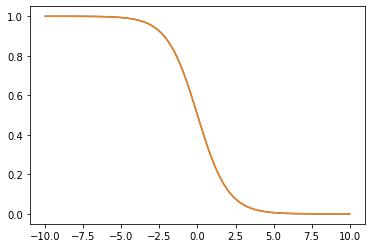

In [204]:
sns.lineplot(xplot,np.diag(cov))


In [197]:
cov.max()

0.999999694097773

In [198]:
cov.min(),cov.max()

(0.006692850924284856, 0.999999694097773)

In [201]:
cov2 = xs.reshape(-1,1).dot(xs.reshape(-1,1).T)

In [205]:
cov2 = np.inner(xs.reshape(-1,1),xs.reshape(-1,1))

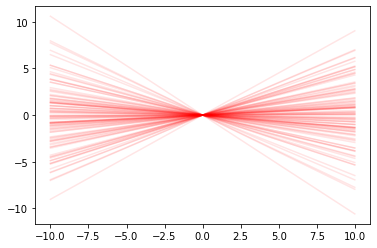

In [216]:
y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=100)
for j in range(len(y)):
    sns.lineplot(xplot,y[j,:],color='red',alpha=0.1)

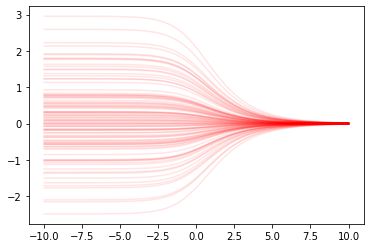

In [206]:
y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov2,size=100)
for j in range(len(y)):
    sns.lineplot(xplot,y[j,:],color='red',alpha=0.1)

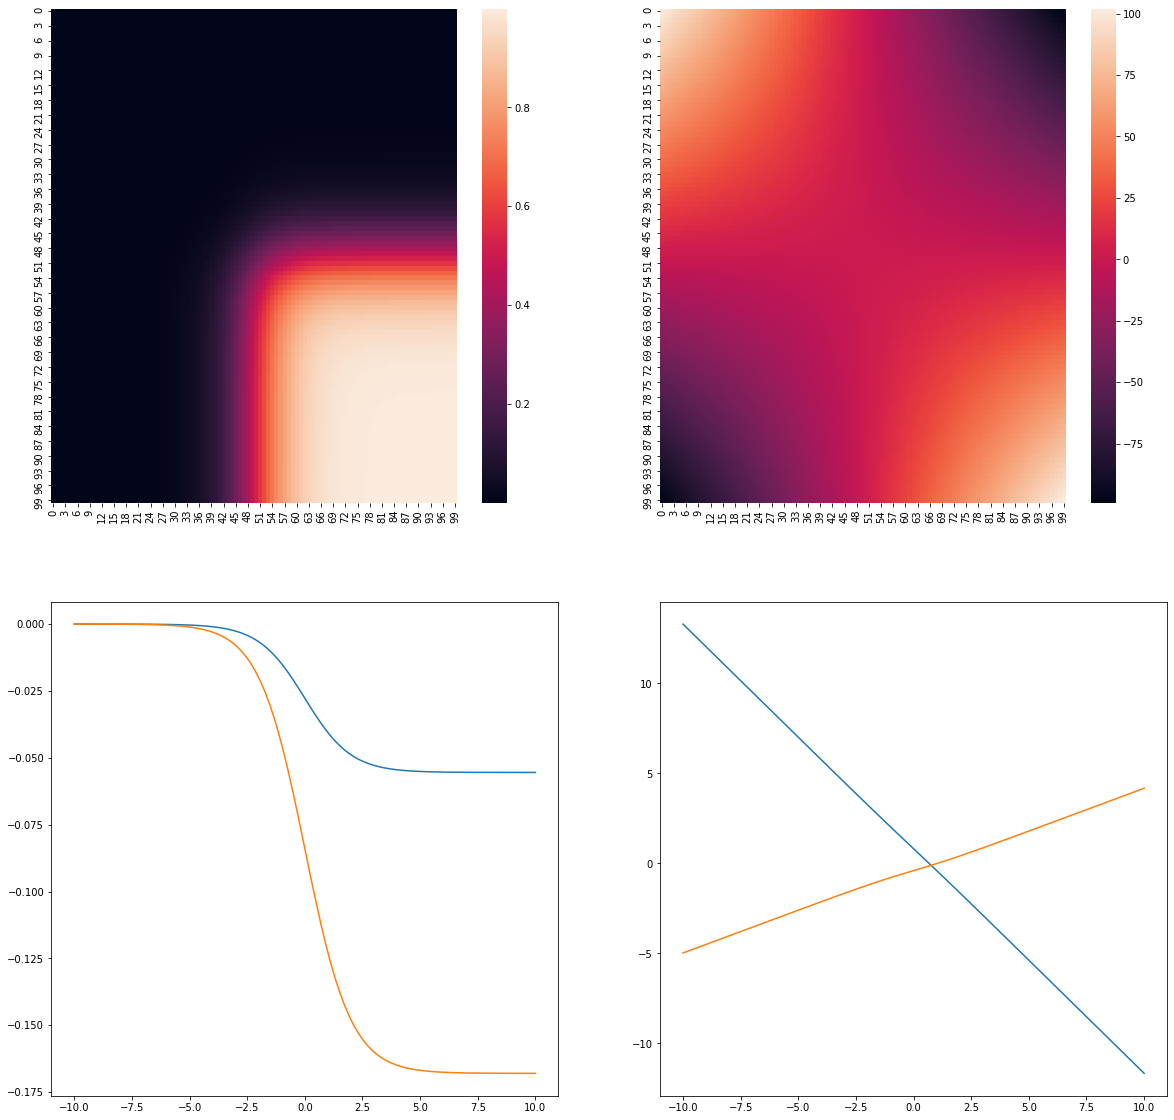

In [249]:
x = np.linspace(-10,10,100)

kernels = [Sigmoid(), Sigmoid() + DotProduct()]
nplots = len(kernels)
plt.figure(figsize=(nplots*10,20))

#change this to see effects of length scale on output 
for i,k in enumerate(kernels):
    plt.subplot(2,nplots,i+1)
    cov  = k.__call__(x.reshape(-1,1),x.reshape(-1,1))
    sns.heatmap(cov)


    #draw some realization  from the Gaussian process
    y = multivariate_normal.rvs(mean=np.zeros_like(x),cov=cov,size=2)
    plt.subplot(2,nplots,nplots+i+1)
    for j in range(len(y)):
        sns.lineplot(x,y[j,:])

In [312]:
xplot = np.linspace(0,10,100)
k1 = DotProduct(0)
cov = k1.__call__(xplot.reshape(-1,1))

In [311]:
cov

array([[ 100.        ,   97.97979798,   95.95959596, ...,  -95.95959596,
         -97.97979798, -100.        ],
       [  97.97979798,   96.00040812,   94.02101826, ...,  -94.02101826,
         -96.00040812,  -97.97979798],
       [  95.95959596,   94.02101826,   92.08244057, ...,  -92.08244057,
         -94.02101826,  -95.95959596],
       ...,
       [ -95.95959596,  -94.02101826,  -92.08244057, ...,   92.08244057,
          94.02101826,   95.95959596],
       [ -97.97979798,  -96.00040812,  -94.02101826, ...,   94.02101826,
          96.00040812,   97.97979798],
       [-100.        ,  -97.97979798,  -95.95959596, ...,   95.95959596,
          97.97979798,  100.        ]])